### Here is my guess for the 2017 UK Snap Election (for Game of Seats).

First, lets assemble some data. This is the votes by party and constituency for the 2015 GE (from http://www.electoralcommission.org.uk/our-work/our-research/electoral-data)

In [4]:
import pandas as pd
GERes=pd.DataFrame.from_csv("/Users/hughosborn/ownCloud/Personal/2015-UK-general-election-data-results-WEB/RESULTS FOR ANALYSIS.csv")

This is the referendum result as a function of constituency (the actual wards were not constituencies, so this has been estimated: https://docs.google.com/spreadsheets/d/1wTK5dV2_YjCMsUYlwg0l48uWWf44sKgG8uFVMv5OWlA/)

In [5]:
RefRes=pd.DataFrame.from_csv("/Users/hughosborn/ownCloud/Personal/LeaveVoteByConstit.csv")

This only has UK (not NI) constituencies, but that's ok.

And the polling data for the major parties since the last GE (from http://ukpollingreport.co.uk/voting-intention-2)

In [6]:
import requests
url = "http://ukpollingreport.co.uk/voting-intention-2"
response = requests.get(url)
PollDat=pd.read_html(response.text,header=0)[0]

I'm using gaussian processes to estimate the future polling of the Tories compared to Labour.
You'll need George 1.0-dev for this bit (https://github.com/dfm/george/tree/1.0-dev)
Defining some functions for a gaussian process fit below:

In [7]:
import matplotlib
from datetime import datetime
dats=[datetime.strptime(PollDat['Survey End Date'][n],'%Y-%m-%d') for n in range(1,PollDat.shape[0])]
mpldats=matplotlib.dates.date2num(dats)

In [8]:
def nll(p,gp,y,prior=[]):
        #inverted LnLikelihood function for GP training
        gp.set_vector(p)
        if prior!=[]:
            #p=a,tau,wn
            if np.any((prior[:,0] > p) + (p > prior[:,1])):
                prob= -np.inf
            gp.set_vector(p)
            prob= gp.lnlikelihood(y, quiet=True)
            return -prob if np.isfinite(prob) else 1e25
        else:
                ll = gp.lnlikelihood(y, quiet=True)
                return -ll if np.isfinite(ll) else 1e25

def grad_nll(p,gp,y,prior=[]):
        #Gradient of the objective function for TrainGP
        gp.set_vector(p)
        return -gp.grad_lnlikelihood(y, quiet=True)

In [9]:
from datetime import datetime as dt
import time

def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [10]:
def GPSmooth(lc,a=1.0,tau=0.1,plot=False,modeloutts=None,ExpSq=True,mean=True):
    import george
    import scipy.optimize as op
    wn=np.median(np.diff(lc[:,1]))
    if ExpSq:
        kernel=a*(george.kernels.ExpSquaredKernel(tau))
    else:
        kernel = a * george.kernels.Matern32Kernel(tau)
    if mean:
        gp = george.GP(kernel, mean=np.nanmean(lc[:,1]), fit_mean=True, white_noise=np.log(wn**2), fit_white_noise=True)
    else:
        
        gp = george.GP(kernel, fit_mean=False, white_noise=np.log(wn**2), fit_white_noise=True)
    gp.compute(lc[:,0],lc[:,2])
    results = op.minimize(nll, gp.get_vector(),args=(gp,lc[:,1]), jac=grad_nll, method="L-BFGS-B")
    gp.set_vector(results.x)

    gp.compute(lc[:,0],lc[:,2])

    #Predicting function for all times
    ypredall,varpredall=gp.predict(lc[:,1], lc[:,0])
    smoothlc=np.copy(lc)#lclam[:,1]/ypredall
    smoothlc[:,1]/=ypredall
    if plot:
        p.figure(1)
        p.errorbar(lc[:,0],lc[:,1],yerr=lc[:,2],ecolor='#CCCCCC',color='b',fmt='.')
        fillx = np.arange(lc[0,0], lc[-1,0], np.min(np.diff(lc[:,0])))
        mu, var = gp.predict(lc[:,1], fillx, return_var=True)
        std = np.sqrt(var)
        p.fill_between(fillx, mu+std, mu-std, color="g", alpha=0.5)
    if modeloutts is not None:
        return smoothlc,gp,gp.predict(lc[:,1],modeloutts,return_var=True)
    else:
        return smoothlc,gp

## Plotting Polling data and extrapolating trends:

Plotting four different models: SqExp, SqExp+mean-function, Matern32,  Matern32+mean-function:

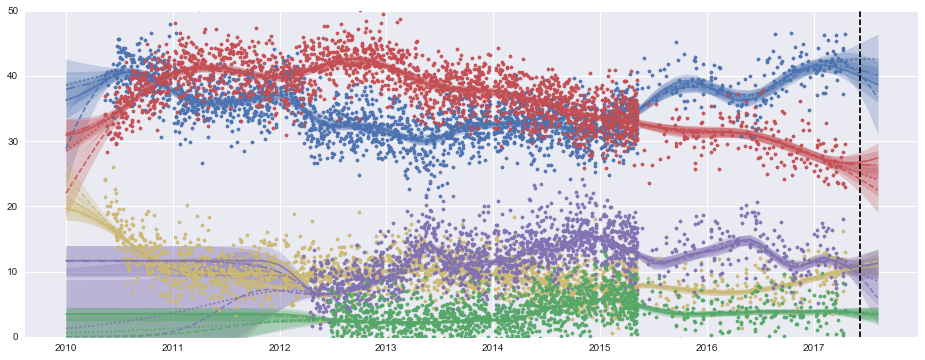

In [17]:
import pylab as plt
import seaborn as sns
import numpy as np
%matplotlib inline
plt.figure(7,figsize=(16,6))

tyrs=(mpldats+np.random.normal(mpldats,np.tile(0.25,len(mpldats))))/365.0
tyrs=np.array([toYearFraction(d) for d in dats[:]])
cols=[0,2,4,3,1]
for n in range(5):
    col=PollDat.columns.values[2+n]
    pollc=np.column_stack((tyrs,np.random.normal(PollDat[col],np.tile(2.0,len(PollDat[col])))[1:],np.sqrt(PollDat[col])[1:]))
    pollc=pollc[pollc[:,0].argsort()]
    pollc=pollc[np.sum(pollc,axis=1)/np.sum(pollc,axis=1)==1.0]
    _,gp,predict=GPSmooth(pollc,modeloutts=np.arange(2010,2017.65,0.1))
    plt.plot(pollc[:,0],pollc[:,1],'.',color=sns.color_palette()[cols[n]],alpha=0.5)
    plt.fill_between(np.arange(2010,2017.65,0.1), predict[0] - np.sqrt(predict[1]), predict[0] + np.sqrt(predict[1]),color=sns.color_palette()[cols[n]], alpha=0.25)
    plt.plot(np.arange(2010,2017.65,0.1),predict[0],'-',color=sns.color_palette()[cols[n]],alpha=0.8)
    _,gp,predict=GPSmooth(pollc,modeloutts=np.arange(2010,2017.65,0.1),mean=False)
    plt.plot(pollc[:,0],pollc[:,1],'.',color=sns.color_palette()[cols[n]],alpha=0.5)
    plt.fill_between(np.arange(2010,2017.65,0.1), predict[0] - np.sqrt(predict[1]), predict[0] + np.sqrt(predict[1]),color=sns.color_palette()[cols[n]], alpha=0.25)
    plt.plot(np.arange(2010,2017.65,0.1),predict[0],'--',color=sns.color_palette()[cols[n]],alpha=0.8)
    _,gp,predict=GPSmooth(pollc,modeloutts=np.arange(2010,2017.65,0.1),ExpSq=False)
    plt.plot(pollc[:,0],pollc[:,1],'.',color=sns.color_palette()[cols[n]],alpha=0.5)
    plt.fill_between(np.arange(2010,2017.65,0.1), predict[0] - np.sqrt(predict[1]), predict[0] + np.sqrt(predict[1]),color=sns.color_palette()[cols[n]], alpha=0.25)
    plt.plot(np.arange(2010,2017.65,0.1),predict[0],'-.',color=sns.color_palette()[cols[n]],alpha=0.8)
    _,gp,predict=GPSmooth(pollc,modeloutts=np.arange(2010,2017.65,0.1),ExpSq=False,mean=False)
    plt.plot(pollc[:,0],pollc[:,1],'.',color=sns.color_palette()[cols[n]],alpha=0.5)
    plt.fill_between(np.arange(2010,2017.65,0.1), predict[0] - np.sqrt(predict[1]), predict[0] + np.sqrt(predict[1]),color=sns.color_palette()[cols[n]], alpha=0.25)
    plt.plot(np.arange(2010,2017.65,0.1),predict[0],':',color=sns.color_palette()[cols[n]],alpha=0.8)
plt.ylim(0,50)
plt.plot([2017.433,2017.433],[0,50],'--k')
plt.savefig("GE2017_polling.png")

Now just plotting it from the 2015GE...

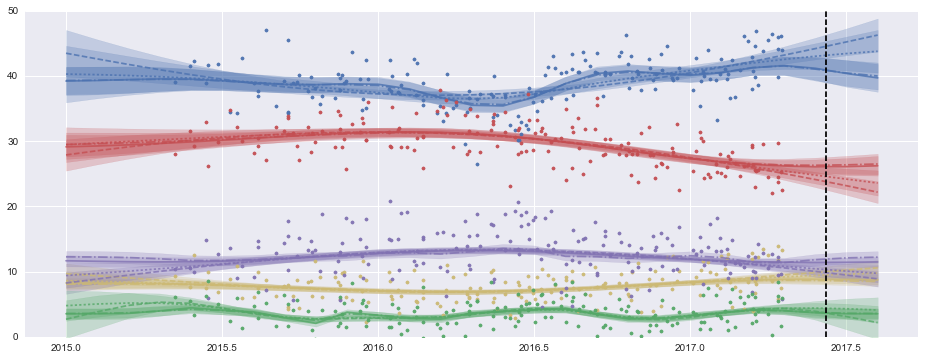

In [18]:
plt.figure(7,figsize=(16,6))

tyrs=(mpldats+np.random.normal(mpldats,np.tile(0.25,len(mpldats))))/365.0
tyrs=np.array([toYearFraction(d) for d in dats[:]])
cols=[0,2,4,3,1]
for n in range(5):
    col=PollDat.columns.values[2+n]
    pollc=np.column_stack((tyrs,np.random.normal(PollDat[col],np.tile(2.0,len(PollDat[col])))[1:],np.sqrt(PollDat[col])[1:]))
    pollc=pollc[pollc[:,0].argsort()]
    pollc=pollc[pollc[:,0]>2015.35]
    pollc=pollc[pollc[:,0].argsort()]
    pollc=pollc[np.sum(pollc,axis=1)/np.sum(pollc,axis=1)==1.0]
    _,gp,predict=GPSmooth(pollc,modeloutts=np.arange(2015,2017.65,0.1))
    plt.plot(pollc[:,0],pollc[:,1],'.',color=sns.color_palette()[cols[n]],alpha=0.5)
    plt.fill_between(np.arange(2015,2017.65,0.1), predict[0] - np.sqrt(predict[1]), predict[0] + np.sqrt(predict[1]),color=sns.color_palette()[cols[n]], alpha=0.25)
    plt.plot(np.arange(2015,2017.65,0.1),predict[0],'-',color=sns.color_palette()[cols[n]],alpha=0.8)
    _,gp,predict=GPSmooth(pollc,modeloutts=np.arange(2015,2017.65,0.1),mean=False)
    plt.plot(pollc[:,0],pollc[:,1],'.',color=sns.color_palette()[cols[n]],alpha=0.5)
    plt.fill_between(np.arange(2015,2017.65,0.1), predict[0] - np.sqrt(predict[1]), predict[0] + np.sqrt(predict[1]),color=sns.color_palette()[cols[n]], alpha=0.25)
    plt.plot(np.arange(2015,2017.65,0.1),predict[0],'--',color=sns.color_palette()[cols[n]],alpha=0.8)
    _,gp,predict=GPSmooth(pollc,modeloutts=np.arange(2015,2017.65,0.1),ExpSq=False)
    plt.plot(pollc[:,0],pollc[:,1],'.',color=sns.color_palette()[cols[n]],alpha=0.5)
    plt.fill_between(np.arange(2015,2017.65,0.1), predict[0] - np.sqrt(predict[1]), predict[0] + np.sqrt(predict[1]),color=sns.color_palette()[cols[n]], alpha=0.25)
    plt.plot(np.arange(2015,2017.65,0.1),predict[0],'-.',color=sns.color_palette()[cols[n]],alpha=0.8)
    _,gp,predict=GPSmooth(pollc,modeloutts=np.arange(2015,2017.65,0.1),ExpSq=False,mean=False)
    plt.plot(pollc[:,0],pollc[:,1],'.',color=sns.color_palette()[cols[n]],alpha=0.5)
    plt.fill_between(np.arange(2015,2017.65,0.1), predict[0] - np.sqrt(predict[1]), predict[0] + np.sqrt(predict[1]),color=sns.color_palette()[cols[n]], alpha=0.25)
    plt.plot(np.arange(2015,2017.65,0.1),predict[0],':',color=sns.color_palette()[cols[n]],alpha=0.8)

plt.ylim(0,50)
plt.plot([2017.433,2017.433],[0,50],'--k')
plt.savefig("GE2017_polling_2016on.png")

Now we probably have to make the constituencies match between GERes and RefRes...

## Modelling the General Election

Right. My model is going to be based on the 2015 election with some tweaks:
* I will account for national poll changes since then by multiplying the 2015 vote of each major party by the poll difference since 2015 (I wont go into demographics though)
* I will also guess polling changes up to GE by choosing a model that brings Labour and Tories a tad closer by the big day (Labour cant do THAT badly, can they?!)
* I will account for remain/leave sentiment with the referendum results by adding con votes in Leave areas and LD votes in remain areas.
* For each party I will also add a random "correlated" 3% country-wide swing and a random local 3% swing.


In [19]:
def RefShift(R16):
    #Given the referendum result in a consteuncy, what is the likely vote shift?
    # Using a completely untested number - every 5% above 50/50 (for remain) produces a 1.5% shift to LDs 
    #    while every 5% below 50/50 gives a 0.75% shift to Labout and a 1% shift to the Tories.
    norm5=(R16['Figure to use']-0.5)/0.05
    return {"lab":0.0075*norm5,"con":0.01*norm5,"ld":-0.015*norm5}

Extrapolting the Exponential Squared /mean function kernel to June 8th. Using the ratio of 2015.5 with 2017.43 as a direct factor on the increase in the vote share.

This makes the assumption that the pollsters fixed their polls after the last GE (which was obviously WAY bluer than expected), hence the post-GE polling was a better representation of the at-GE proportions.

If I use the pre-GE polling as the baseline, the Tories are going to get an even bigger boost.

In [20]:
extrapdic={}
for n in range(5):
    col=PollDat.columns.values[2+n]
    extraplc=np.column_stack((tyrs,np.random.normal(PollDat[col],np.tile(2.0,len(PollDat[col])))[1:],np.sqrt(PollDat[col])[1:]))
    extraplc=extraplc[extraplc[:,0].argsort()]
    extraplc=extraplc[np.sum(extraplc,axis=1)/np.sum(extraplc,axis=1)==1.0]
    _,extrapgp,extrappredict=GPSmooth(extraplc,modeloutts=[2015.5,2017.43])
    extrapdic[col.split(' ')[0]]=extrappredict[0][1]/extrappredict[0][0]
    extrapdic[col.split(' ')[0]+"_err"]=np.sqrt((np.sqrt(extrappredict[1][1])/extrappredict[0][1])**2+(np.sqrt(extrappredict[1][0])/extrappredict[0][0])**2)

In [55]:
# That gives the relative vote share shares as shown below:
extrapdic

{u'CON': 1.0908078170187561,
 u'CON_err': 0.049973486861328964,
 u'Grn': 1.0361926360267355,
 u'Grn_err': 0.22602467477017124,
 u'LAB': 0.8156927742209551,
 u'LAB_err': 0.062479520298381365,
 u'LD': 1.3002261802309054,
 u'LD_err': 0.12066881860029022,
 u'UKIP': 0.96078473076065252,
 u'UKIP_err': 0.17660133460756564}

Running the numbers on a per-constituency basis across the UK:

In [22]:
RefRes.sort_index(inplace=True)

In [23]:
#Finding where the NI constituencies are in the index
NIconsts=np.arange(1,650)[~np.in1d(np.arange(1,650),RefRes.index.values)]

In [24]:
def RunElection():
    #Function with which to run an election
    scores=np.zeros((650,6))
    #Correlated UK-wide vote changes up to 3%
    corrinc=np.random.normal(np.tile(0,6),np.tile(3,6))
    
    #Looping through UK constituencies
    for row in RefRes.iterrows():
        G15=GERes.loc[row[0]]
        R16=row[1]
        refshift=RefShift(R16) #Adding shift from LD->Con in leave areas and vice versa in remain areas
        
        #Finding votes from major parties:
        votes=np.zeros(6)
        tot=int(G15[' Total number of valid votes counted '].replace(',',''))
        
        #Labour
        if 'Lab Co-op' in G15.index:#Some regions have a "Lab Co-op" coalition. Adding these to the Lab score
            G15['Lab']=np.nanmax([G15['Lab Co-op'],G15['Lab']])
        if 'Lab' in G15.index and not pd.isnull(G15.Lab).any():
            votes[0]=G15.Lab*np.random.normal(extrapdic['LAB'],extrapdic['LAB_err'])+tot*np.random.normal(refshift['lab'],abs(refshift['lab']/2.0))
            votes[0]+=np.random.normal(0.0,3.0)#Adding extra 3% of local uncertainty for all parties
            votes[0]+=corrinc[0]
            votes[0]=abs(votes[0])
        #Tories
        if 'C' in G15.index and not pd.isnull(G15.C).any(): 
            votes[1]=G15.C*np.random.normal(extrapdic['CON'],extrapdic['CON_err'])+tot*np.random.normal(refshift['con'],abs(refshift['con']/2.0))
            votes[1]+=np.random.normal(0.0,3.0)#Adding extra 3% of local uncertainty for all parties
            votes[1]+=corrinc[1]
            votes[1]=abs(votes[1])
        #Lib Dems
        if 'LD' in G15.index and not pd.isnull(G15.LD).any(): 
            votes[2]=G15.LD*np.random.normal(extrapdic['LD'],extrapdic['LD_err'])+tot*np.random.normal(refshift['ld'],abs(refshift['ld']/2.0))
            votes[2]+=np.random.normal(0.0,3.0)#Adding extra 3% of local uncertainty for all parties
            votes[2]+=corrinc[2]
            votes[2]=abs(votes[2])
        #SNP
        if 'SNP' in G15.index and not pd.isnull(G15.SNP).any(): 
            votes[3]=G15.SNP*np.random.normal(1.0,0.05)
            votes[3]+=np.random.normal(0.0,3.0)#Adding extra 3% of local uncertainty for all parties
            votes[3]+=corrinc[3]
            votes[3]=abs(votes[3])
        #UKIP
        if 'UKIP' in G15.index and not pd.isnull(G15.UKIP).any(): 
            votes[4]=G15.UKIP*np.random.normal(extrapdic['UKIP'],extrapdic['UKIP_err'])
            votes[4]+=np.random.normal(0.0,3.0)#Adding extra 3% of local uncertainty for all parties
            votes[4]+=corrinc[4]
            votes[4]=abs(votes[4])
        #Grn=G15.LD*np.random.normal(extrapdic['Grn'],extrapdic['Grn_err'])
        oths=G15.index.values[~np.in1d(G15.index.values,np.array(['Lab','Lab Co-op','C','LD','SNP','UKIP']))][8:-2]
        for o in oths:
            count=G15[o]
            if ~(pd.isnull(count))*~(np.isnan(count))*(count>votes[5]):
                votes[5]=count
                votes[5]+=np.random.normal(0.0,3.0)#Adding extra 3% of uncertainty for all parties
                votes[5]+=corrinc[5]
                votes[5]=abs(votes[5])
        
        scores[row[0]-1,:]=votes
    
    #Doing NI constituencies:
    for n in NIconsts:
        votes=np.zeros(6)
        G15=GERes.loc[n]
        votes[5]=np.max(G15.iloc[8:-2])
        scores[n-1,:]=votes
        votes[5]+=np.random.normal(0.0,5.0)
    
    #Finding total winners:
    names=["Lab","Con","LD","SNP","UKIP","Other"]
    winners=np.argmax(scores,axis=1)
    hist=[np.sum(winners==i) for i in range(6)]
    return hist, scores


## Running the model

Doing this on 100 elections:

In [58]:
hists=np.zeros((100,6))
contscores=np.zeros((100,650,6))
for n in range(100):
    h,s=RunElection()
    hists[n,:]=h
    contscores[n,:,:]=s

/Users/hughosborn/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [59]:
print "Likely vote shares of the major parties (and 1-sigma ranges) are: "
print [names[h]+str(np.percentile(hists[:,h],[16,50,84]))+"\n" for h in range(6)]

Likely vote shares of the major parties (and 1-sigma ranges) are: 
['Labour[ 173.  177.  180.]\n', 'Tories[ 368.  371.  374.]\n', 'Liberal Democrats[ 23.  25.  27.]\n', 'SNP[ 51.  52.  54.]\n', 'UKIP[ 0.  1.  2.]\n', 'Others[ 24.  24.  24.]\n']


Plotting these:

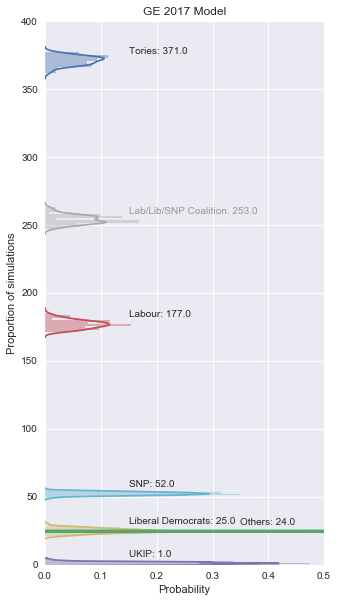

In [66]:
plt.figure(19,figsize=(5,10))
cols=[2,0,4,5,3,1]
names=["Labour","Tories","Liberal Democrats","SNP","UKIP","Others"]
for h in range(6):
    sns.distplot(hists[:,h],vertical=True,color=sns.color_palette()[cols[h]])
    plt.ylim(0,400)
    if h==5:
        plt.text(0.35,5+np.median(hists[:,h]),names[h]+": "+str(np.median(hists[:,h])))
    else:
        plt.text(0.15,5+np.median(hists[:,h]),names[h]+": "+str(np.median(hists[:,h])))
    #plt.xscale('log')

liblabsnp=hists[:,0]+hists[:,2]+hists[:,3]
sns.distplot(liblabsnp,vertical=True,color='#AAAAAA')
plt.text(0.15,5+np.median(liblabsnp),"Lab/Lib/SNP Coalition: "+str(np.median(liblabsnp)),color='#999999')
    
plt.xlim(0,0.5)
plt.title("GE 2017 Model")
plt.xlabel("Probability")
plt.ylabel("Proportion of simulations")
plt.savefig("GEmodelOutput")

#### Checking where independents win:

In [63]:
medcont=np.median(contscores,axis=0)
GERes.loc[np.where(medcont[:,5]>np.nanmax(medcont[:,:5],axis=1))[0]+1,['Constituency Name','C','Lab','Lab Co-op','LD','PC','SNP','DUP']]

,Constituency Name,C,Lab,Lab Co-op,LD,PC,SNP,DUP
Press Association ID Number,,,,,,,,
13.0,Antrim East,549.0,NaN,NaN,NaN,NaN,NaN,12103.0
14.0,Antrim North,368.0,NaN,NaN,NaN,NaN,NaN,18107.0
15.0,Antrim South,415.0,NaN,NaN,NaN,NaN,NaN,10993.0
16.0,Arfon,3521.0,8122.0,NaN,718.0,11790.0,NaN,NaN
45.0,Belfast East,1121.0,NaN,NaN,NaN,NaN,NaN,19575.0
46.0,Belfast North,NaN,NaN,NaN,NaN,NaN,NaN,19096.0
47.0,Belfast South,582.0,NaN,NaN,NaN,NaN,NaN,8654.0
48.0,Belfast West,34.0,NaN,NaN,NaN,NaN,NaN,2773.0
98.0,Brighton Pavilion,12448.0,14904.0,NaN,1525.0,NaN,NaN,NaN


That all looks ok.

### Some interesting Constituencies..?

Lets have a look at the tightest likely election results:

In [67]:
for m in range(650):
    if (np.sort(medcont[m])[-1]-np.sort(medcont[m])[-2])<1000:
        print GERes.loc[m+1,'Constituency Name']+" \t \t - "+names[np.argmax(medcont[m])]+" to win by "+str(int(np.sort(medcont[m])[-1]-np.sort(medcont[m])[-2]))+" votes"
        
#GERes.loc[np.array(tights)+1,['Constituency Name','C','Lab','Lab Co-op','LD','PC','SNP','DUP']]

Batley & Spen 	 	 - Labour to win by 124 votes
Berwickshire, Roxburgh & Selkirk 	 	 - Tories to win by 883 votes
Birmingham Erdington 	 	 - Labour to win by 801 votes
Bishop Auckland 	 	 - Tories to win by 915 votes
Bolton North East 	 	 - Tories to win by 447 votes
Bradford East 	 	 - Labour to win by 884 votes
Bristol East 	 	 - Tories to win by 569 votes
Burnley 	 	 - Liberal Democrats to win by 153 votes
Bury South 	 	 - Tories to win by 378 votes
Caithness, Sutherland & Easter Ross 	 	 - SNP to win by 328 votes
Clacton 	 	 - Tories to win by 418 votes
Clwyd South 	 	 - Tories to win by 965 votes
Coventry North West 	 	 - Tories to win by 333 votes
Dudley North 	 	 - Tories to win by 120 votes
Ellesmere Port & Neston 	 	 - Labour to win by 747 votes
Hammersmith 	 	 - Labour to win by 762 votes
Hyndburn 	 	 - Tories to win by 332 votes
Mansfield 	 	 - Labour to win by 8 votes
Newport West 	 	 - Tories to win by 915 votes
Ross, Skye & Lochaber 	 	 - Liberal Democrats to win by 277 vo

And some slightly less close (1000-2000)

In [68]:
for m in range(650):
    if 1000<(np.sort(medcont[m])[-1]-np.sort(medcont[m])[-2])<2000:
        print GERes.loc[m+1,'Constituency Name']+" \t \t - "+names[np.argmax(medcont[m])]+" to win by "+str(int(np.sort(medcont[m])[-1]-np.sort(medcont[m])[-2]))+" votes"


Alyn & Deeside 	 	 - Tories to win by 1299 votes
Blackpool South 	 	 - Tories to win by 1132 votes
Bridgend 	 	 - Tories to win by 1923 votes
Cheadle 	 	 - Tories to win by 1831 votes
Cheltenham 	 	 - Tories to win by 1177 votes
Chorley 	 	 - Tories to win by 1529 votes
Copeland 	 	 - Tories to win by 1602 votes
Coventry South 	 	 - Tories to win by 1594 votes
Darlington 	 	 - Tories to win by 1634 votes
Delyn 	 	 - Tories to win by 1307 votes
Eastbourne 	 	 - Liberal Democrats to win by 1098 votes
Exeter 	 	 - Labour to win by 1196 votes
Fife North East 	 	 - Liberal Democrats to win by 1533 votes
Great Grimsby 	 	 - Labour to win by 1248 votes
Leeds North East 	 	 - Labour to win by 1730 votes
Luton South 	 	 - Labour to win by 1021 votes
Manchester Withington 	 	 - Labour to win by 1248 votes
Newport East 	 	 - Labour to win by 1037 votes
Nottingham South 	 	 - Labour to win by 1764 votes
Oldham East & Saddleworth 	 	 - Labour to win by 1437 votes
Penistone & Stocksbridge 	 	 - Labo

In [71]:
winnerstable=[]
for m in range(650):
    winnerstable+=[[GERes.loc[m+1,'Constituency Name']+"\t"+names[np.argmax(medcont[m])]+" win by "+str(int(np.sort(medcont[m])[-1]-np.sort(medcont[m])[-2]))+" votes",int(np.sort(medcont[m])[-1]-np.sort(medcont[m])[-2])]]
winnerstable=np.array(winnerstable)
winnerstable=winnerstable[winnerstable[:,1].astype(int).argsort()]
fout=open("ConstWinners.txt","wa")
for line in winnerstable[:,0]:
    fout.write(line+"\n")
fout.close

<function close>